# Convolutional Neural Networks

The CNN assumes that the data has a **grid-like topology**

Examples of grid-like data include:
- Time series data, which can be thought of as a 1-D grid taking samples at regular intervals
- Image data, which can be thought of as a 2-D grid of pixels  

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## What is the Convolution operation?

Mathematically, we define a 2-D kernel as a function $K(m, n)$ taking two variable indices $m, n$ since we have two dimensions.

Then, given an image $I(i, j)$ where $i$ indexes into the rows and $j$ indexes into the columns of the image, the 2-D convolution is defined as:

$$
    H(i, j) = (K \ast I)(i, j) = \sum_m \sum_n I(i+m, j+n) K(m, n)
$$

In practice, the kernel function is not implemented as a function, but rather as a lookup table, which we can regard as a 2 dimensional matrix.  

Strictly speaking, this is not called **convolution** but **cross-correlation**, but the deeplearning community has adopted the naming convention. Actual convolution is almost the same except that the plus (+) signs are flipped. 

### Convolution on 2D input

(torch.Size([10, 10]), torch.Size([3, 3]), torch.Size([7, 7]))

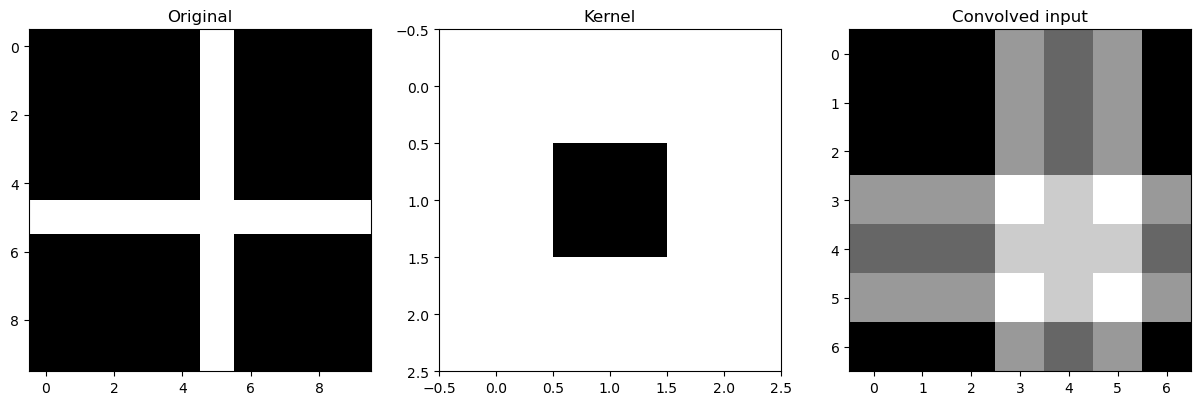

In [8]:
# input in the form of a cross
X = torch.zeros(10, 10)
X[:, 5] = 1
X[5] = 1

# kernel
n = 3
kernel = torch.tensor([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]
])

# output
H = torch.zeros(10-n, 10-n)
# apply convolution
for j in range(X.shape[0]-n):
    for i in range(X.shape[1]-n):
        H[j, i] = torch.sum(X[j:j+n, i:i+n] * kernel)
    
# visualize original, kernel, and convolved output
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(X, cmap="gray")
axes[0].set_title('Original')

axes[1].imshow(kernel, cmap="gray")
axes[1].set_title('Kernel')

axes[2].imshow(H, cmap="gray")
axes[2].set_title('Convolved input')

X.shape, kernel.shape, H.shape

### Convolution on image

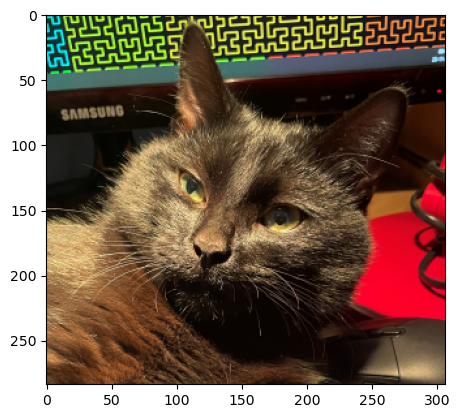

In [9]:
from PIL import Image

img = Image.open('../datasets/kat.png')
img.load()
img = torch.tensor(np.asarray(img, dtype='int32'))

plt.imshow(img, cmap="gray")

Text(0.5, 1.0, 'Conv2d')

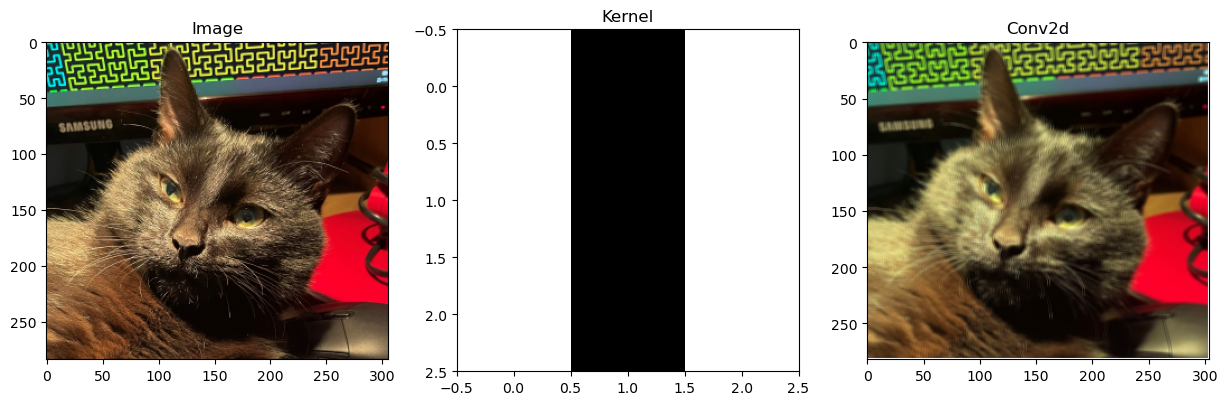

In [10]:
# function that maps x, which is defined between in_min and in_max to a range between out_min and out_max
def map_val(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

# 'naive' convolution operation on input X of shape (height, width, color)  
def convolution(X: torch.Tensor, kernel: torch.Tensor):
    
    h, w = kernel.shape
    H = torch.zeros(X.shape[0]-h+1, X.shape[1]-w+1, X.shape[2], dtype=torch.int32)
    
    for j in range(X.shape[0]-h):
        for i in range(X.shape[1]-w):
            for k in range(X.shape[2]):
                H[j, i, k] = torch.sum(X[j:j+h, i:i+w, k] * kernel)
    
    for k in range(X.shape[2]):
        H[:, :, k] = map_val(H[:, :, k], H[:, :, k].min(), H[:, :, k].max(), 0, 255).type(torch.int32)
    
    return H

# example kernel
kernel = torch.tensor([
    [10, 0, 10],
    [10, 0, 10],
    [10, 0, 10]
])

H = convolution(img, kernel)

# visualize image, kernel, and convolved image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Image")
axes[1].imshow(kernel, cmap="gray")
axes[1].set_title("Kernel")
axes[2].imshow(H, cmap="gray")
axes[2].set_title("Conv2d")

## ConvLayer in Pytorch

**Parameters for convolution (2D cross-correlation):**
- kernel shape $(H_k \times W_k)$
- padding shape $(H_p \times  W_p)$
- stride shape $(H_s \times  W_s)$

After the application of the convolution operation on an image $I$ with shape $(H \times W)$, its new shape becomes:
$$
    I_{\text{new}}: \left(\dfrac{H - H_k + H_p + H_s}{H_s} \times \dfrac{W - W_k + W_p + W_s}{W_s} \right)
$$


In [30]:
N = 1
n_color = 4
width = 28
height = 28

X = torch.randn(N, n_color, width, height)

n_out_channels = 10

conv = nn.Conv2d(
    in_channels=n_color, 
    out_channels=n_out_channels, 
    kernel_size=(3, 3), 
    padding=(4, 4),
    stride=(1, 1)
)

Y = conv(X)

X.shape, Y.shape

(torch.Size([1, 4, 28, 28]), torch.Size([1, 10, 34, 34]))

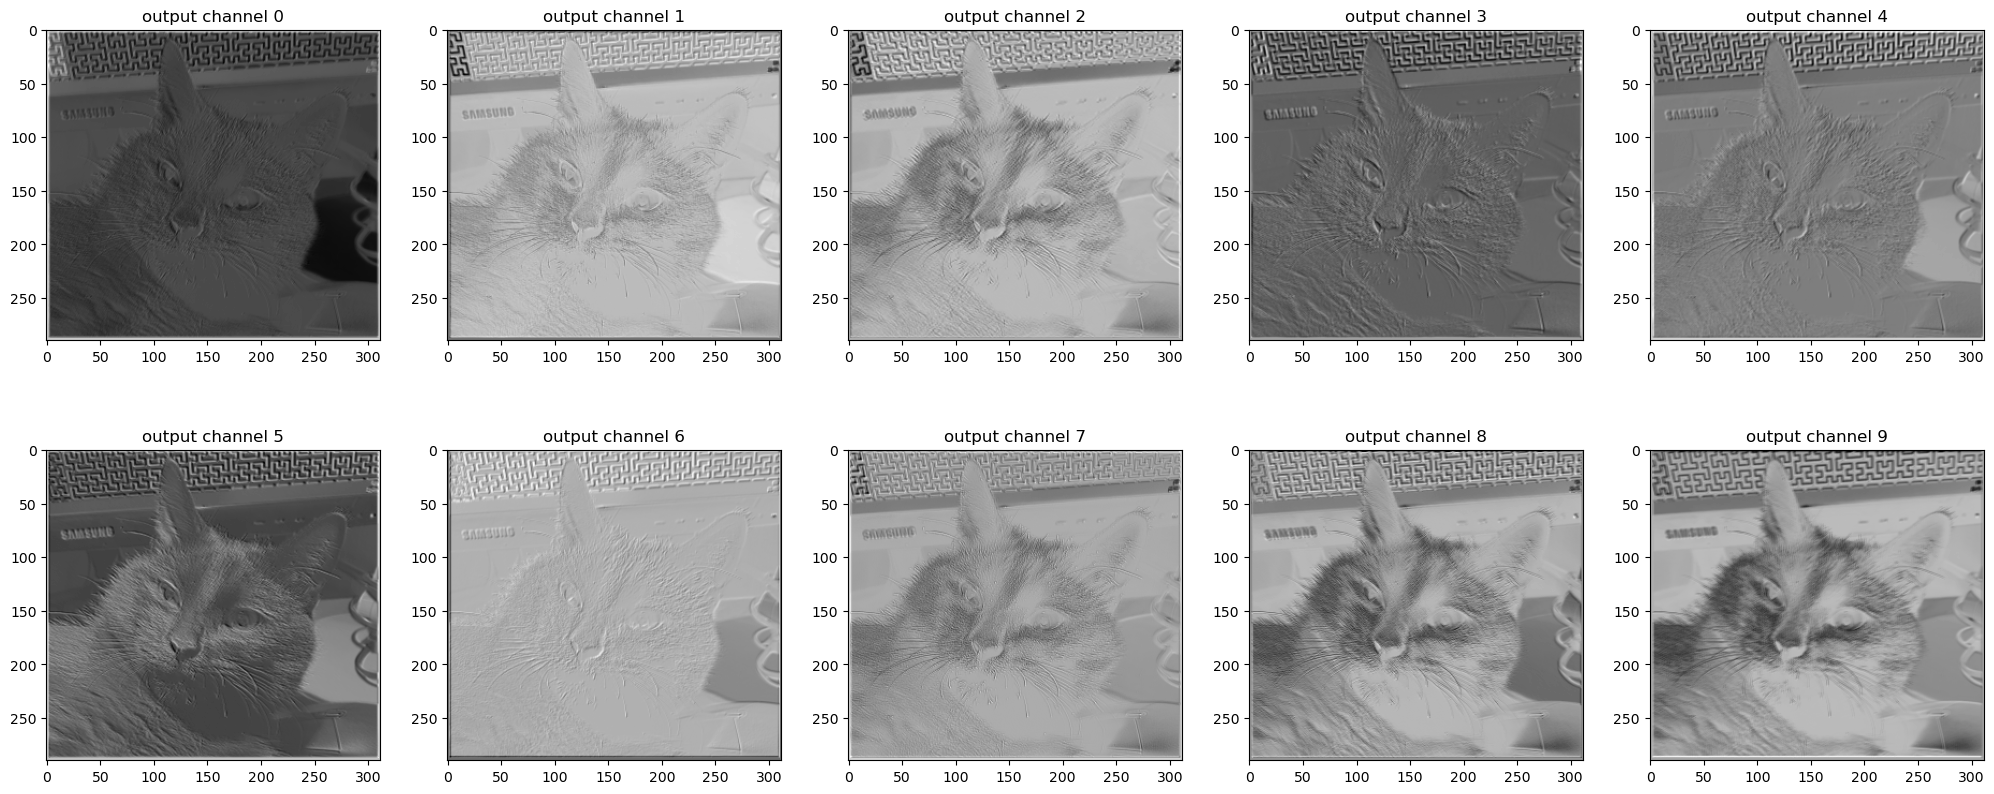

In [33]:
# we need to transpose the image so that its shape (width, height, 4) becomes (4, width, height)
img_transposed = img.to(torch.float32).permute(2, 0, 1)

Y = conv(img_transposed)

# visualize each output channel
num_rows = n_out_channels // 5
fig, axes = plt.subplots(num_rows, 5, figsize=(5*5, 5*num_rows))
axes = axes.flatten()

Y_squeezed = Y.squeeze()
for ax, dim in zip(axes, range(Y.shape[1])):
    ax.set_title(f"output channel {dim}")
    ax.imshow(Y_squeezed[dim].detach().numpy(), cmap='gray')

Three key ideas of CNNs:
- **Sparse interactions**: traditional NN layers (such as the linear layer) use weighted sums between inputs and weights. The connectivity between inputs and outputs is very dense, meaning that each output is produced by a weighted combination of every single input. CNNs have sparse connections between inputs and outputs by sliding a small window over the input data and multiplying the values with the window weights. This window is called the kernel. In effect, this means that we need to store fewer weight parameters and it leads to statistical efficiency. 
  
- **Parameter sharing**: refers to using the same parameter for more than one function in the model. For example, consider processing an input image of shape `(100, 100, 3)`, i.e., 100 by 100 by 3 color channels. This means we have 30000 pixels that would each need a connection (and thus a weight parameter) to a single output. Instead, CNNs use small kernels that slide over the large image which results in sharing of parameters. 

- **Equivariance to translation**: because we use kernels as sliding windows over the input image, it has a pleasant side-effect. It means that CNNs are now equivariant to translations. Simply put, this means that if the input changes, the output changes in the same way. In other words, a function $f(x)$ is equivariant to another function $g(x)$ if $f(g(x)) = g(f(x))$, where in the case of convolution, we can let $g$ be a function that translates (or moves/shifts) the image in a given direction.  

## Pooling layers

A typical layer of a convolutional network consists of 3 stages:
- **Convolution stage** where we apply a convolutional transformation
- **Detector stage** where we apply a non-linear activation function, e.g., ReLU
- **Pooling stage** where we summarize nearby activations at particular locations

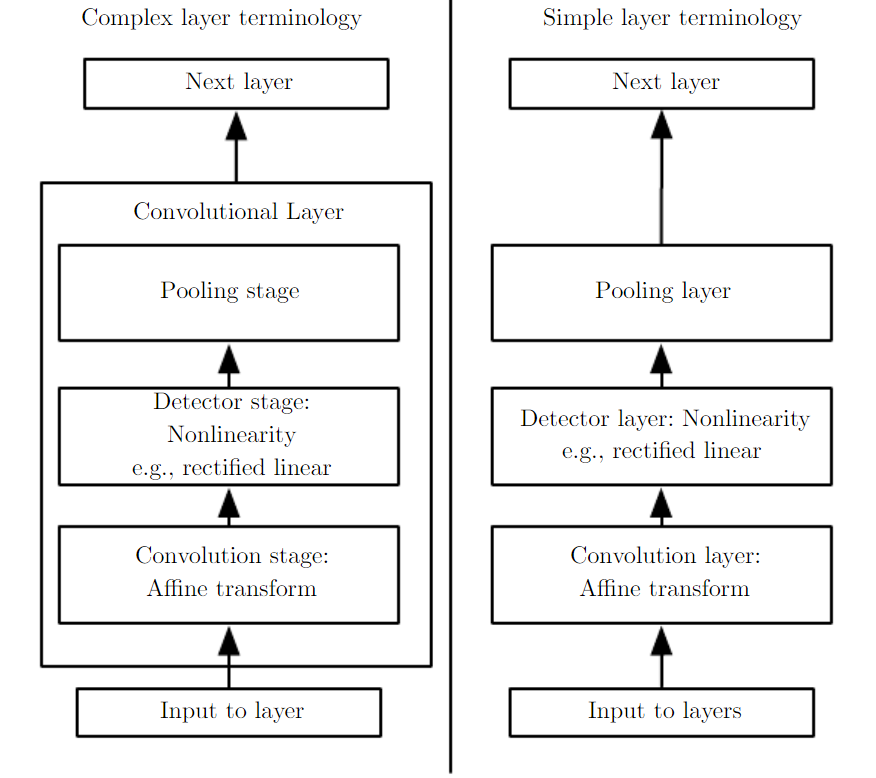

There are two commonly used pooling functions:
- **max-pooling**: take maximum of adjacent activations
- **average-pooling**: take average of adjacent activations

In [38]:
max_pooling = nn.MaxPool2d(
    kernel_size=(3, 3), 
    stride=(1, 1)
)

X = torch.randn(1, 10, 10)
Y_max = max_pooling(X)
X.shape, Y_max.shape

(torch.Size([1, 10, 10]), torch.Size([1, 8, 8]))

## Implementation of the original LeNet model

The CNN was first proposed by [*Yan LeCun et al.*](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) in 1998.

We will reproduce this revolutionizing model using modern deeplearning tooling. LeCun's CNN, called `LeNet`, was proposed for the recognition of hand-written digits. The model expects black-and-white input images of shape $(28 \times 28)$, and produces 10 outputs. Each output denotes the probability of the input being a particular digit. A standard image dataset called the MNIST dataset was used. It contains 60000 training examples and 10000 test examples. 

For example, if we write a `7` on a piece of paper, scan in it, format it so that it is $(28 \times 28)$, and feed it into a **trained** LeNet model, we will be left with something like the following:

|index|0|1|2|3|4|5|6|7|8|9|
|-|-|-|-|-|-|-|-|-|-|-|
|value|0|0.2|0|0|0|0|0|0.8|0|0|0|

You can see that the model puts alot of trust ($80\%$) in the correct prediction being `7`, and the model is $20\%$ certain that the written `7` is actually a `1`. You can reason why this is the case, as the `7` and `1` may look alike in cursive.   

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lenet = nn.Sequential(
    # conv block 1: 28 -> 12
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),   # 28 -> 24
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),                                          # 24 -> 12
    # conv block 2: 12 -> 4
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),  # 12 -> 8
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),                                          # 8 -> 4
    # dense MLP
    nn.Flatten(),                                                                   # 16*4*4 = 256 units
    nn.Linear(256, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10) # 10 classes in MNIST
).to(device)

X = torch.randn(1, 1, 28, 28).to(device)
lenet(X).shape

torch.Size([1, 10])

### Laad train/test sets

In [41]:
import torchvision
import torchvision.transforms as transforms

DOWNLOAD_PATH = '../datasets'

# normalize so that the mean of the data is zero and the variance is one
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

train = torchvision.datasets.MNIST(root=DOWNLOAD_PATH, train=True, download=True, transform=transform)
test_val = torchvision.datasets.MNIST(root=DOWNLOAD_PATH, train=False, download=True, transform=transform)
test, val = torch.utils.data.random_split(test_val, [0.5, 0.5])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8111175.39it/s] 


Extracting ../datasets\MNIST\raw\train-images-idx3-ubyte.gz to ../datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 330336.44it/s]


Extracting ../datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ../datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2928645.70it/s]


Extracting ../datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ../datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4535840.18it/s]

Extracting ../datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../datasets\MNIST\raw



### Training loop

epoch: 0	train loss: 1.2233	val loss: 0.3104
epoch: 1	train loss: 0.2318	val loss: 0.1449
epoch: 2	train loss: 0.1405	val loss: 0.0990
epoch: 3	train loss: 0.1068	val loss: 0.0836
epoch: 4	train loss: 0.0868	val loss: 0.0653


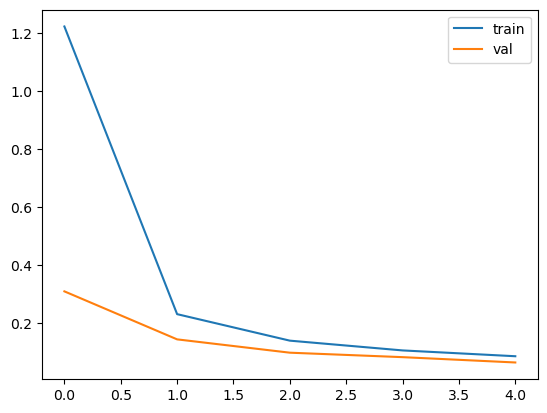

In [42]:
from torch.utils.data import DataLoader

EPOCHS = 5

train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=len(test), shuffle=True)
val_loader = DataLoader(val, batch_size=len(val), shuffle=True)

optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_history = []
val_history = []

for e in range(EPOCHS):
    batch_history = []
    # TRAIN STEP
    for images, labels in train_loader:
        # convert images to the correct device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        # predict and compute loss
        preds = lenet(images)
        loss = criterion(preds, labels)
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_history.append(np.mean(batch_history))

    batch_history = []
    # VALIDATION STEP
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            preds = lenet(images)
            loss = criterion(preds, labels)
            batch_history.append(loss.item())
        val_history.append(np.mean(batch_history))
    
    print(f"epoch: {e}\ttrain loss: {train_history[-1]:.4f}\tval loss: {val_history[-1]:.4f}")

plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.legend()

In [58]:
# TEST STEP
with torch.no_grad():
    test_loss = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = lenet(images)
        loss = criterion(preds, labels)
        test_loss += loss.item()
    print(f"test loss: {test_loss / len(test_loader)}")

test loss: 0.07473325729370117


### Let's visualize what LeNet has learned

In [51]:
features = {} #dictionary that will store results!

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

hook_handles = []

Here we register hooks for each intermediate computation result

In [52]:
for i, m in enumerate(lenet.children()):
    h = m.register_forward_hook(get_features(f"{i}{type(m).__name__}"))
    hook_handles.append(h)

In [53]:
hook_handles

Let's see how the model performs on a given input

{0: -3.1508915424346924,
 1: -1.6379233598709106,
 2: -0.8730409741401672,
 3: -7.090384006500244,
 4: 7.5701212882995605,
 5: -3.573336124420166,
 6: -0.053023889660835266,
 7: -0.35782405734062195,
 8: -0.8336890935897827,
 9: 1.4521701335906982}

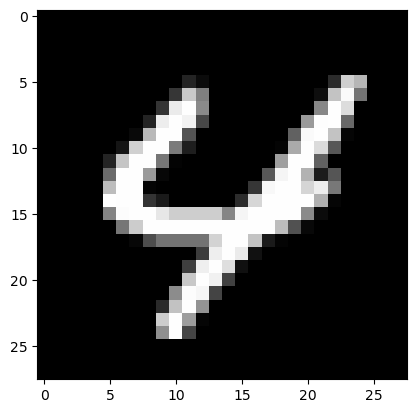

In [54]:
idx = 56

image_sample, label = test[idx]

y_pred = lenet(image_sample[None, :].to(device))

plt.imshow(image_sample.squeeze(), cmap='gray')

y_mapping = {i: yi.item() for i, yi in enumerate(y_pred.cpu()[0])}

y_mapping

Now we can analyze what the intermediate steps of the forward pass are

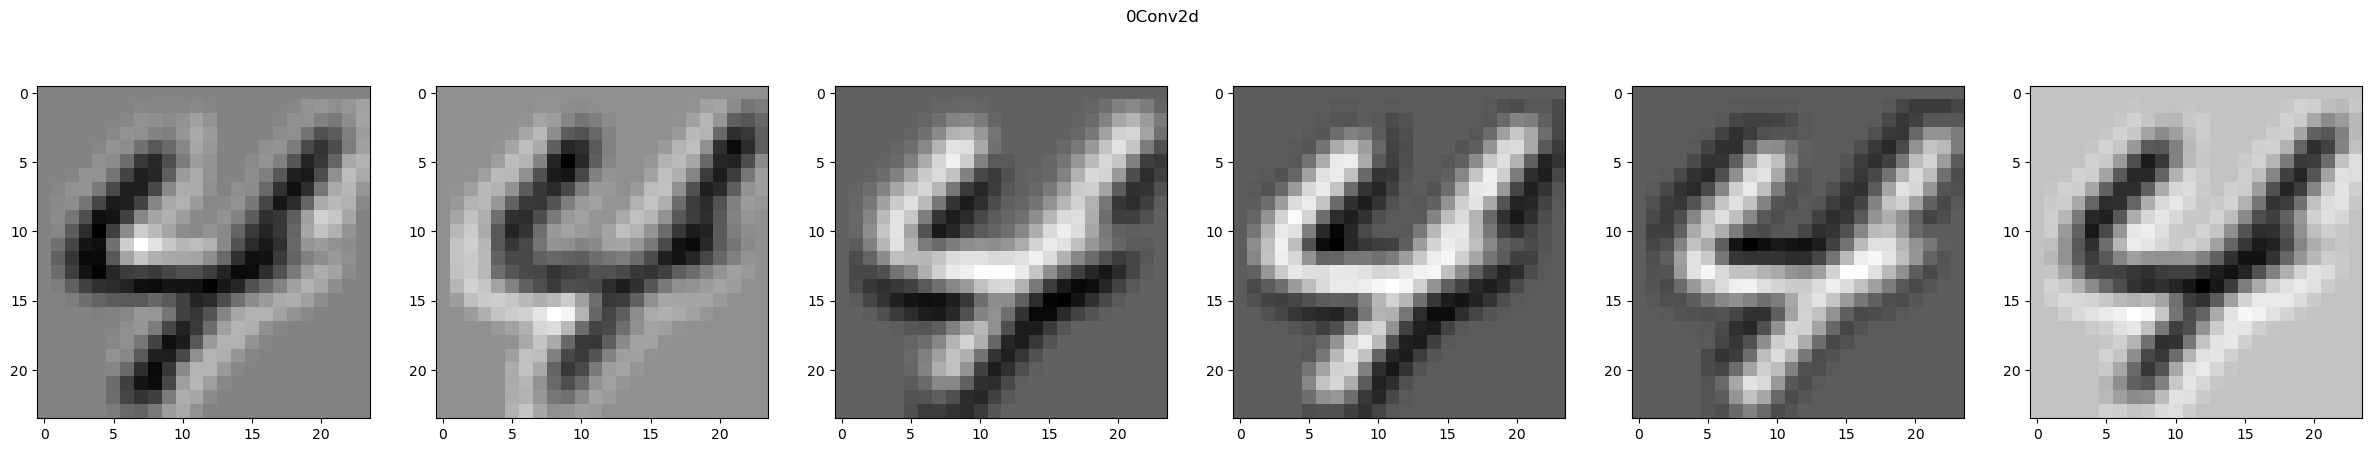

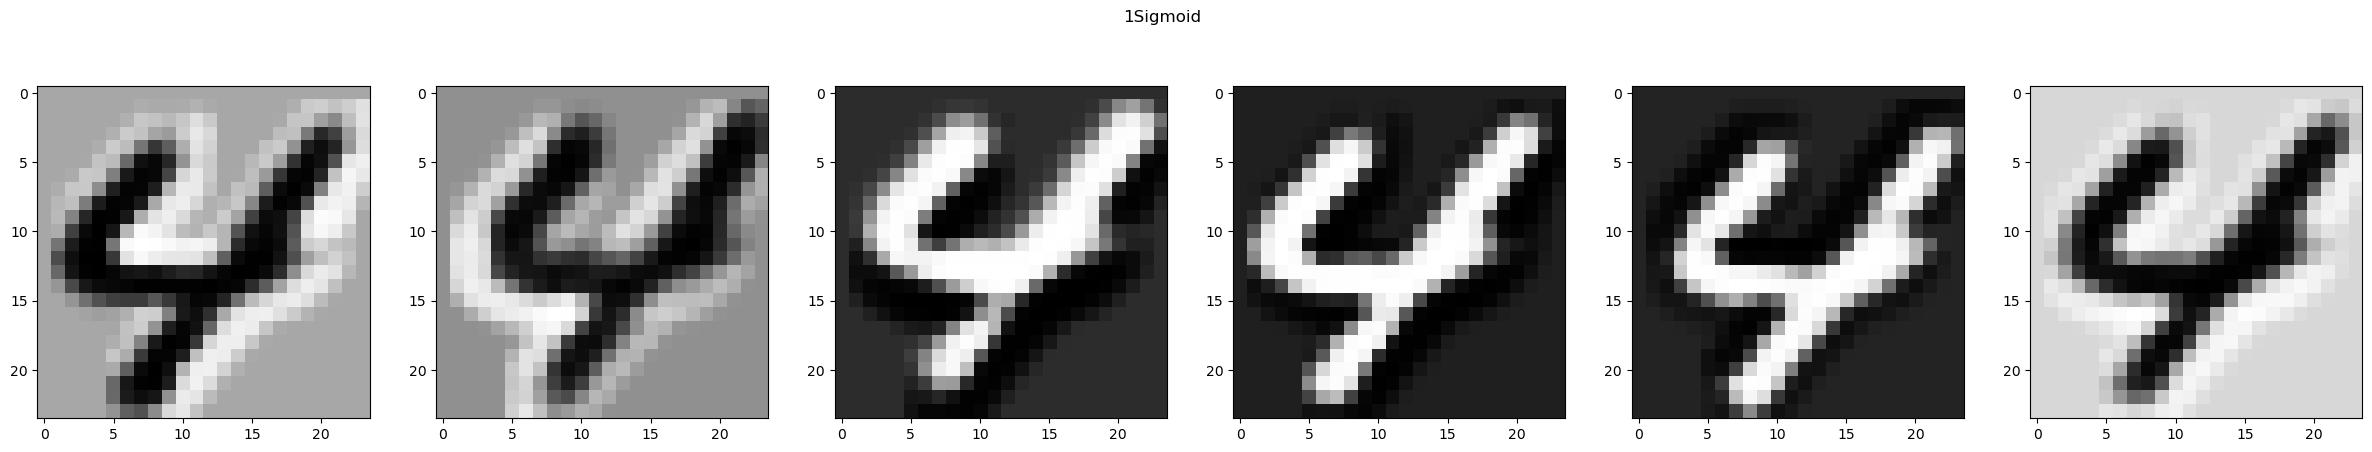

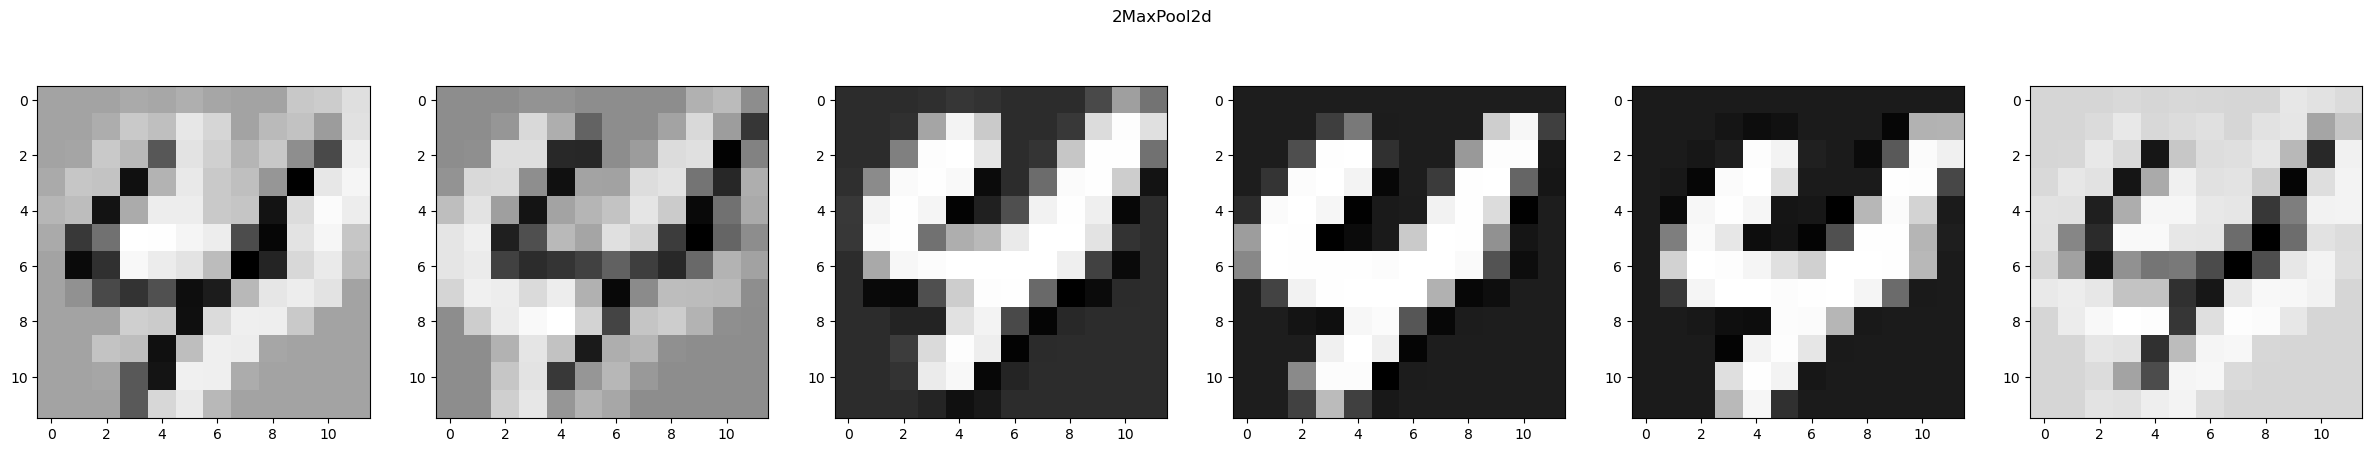

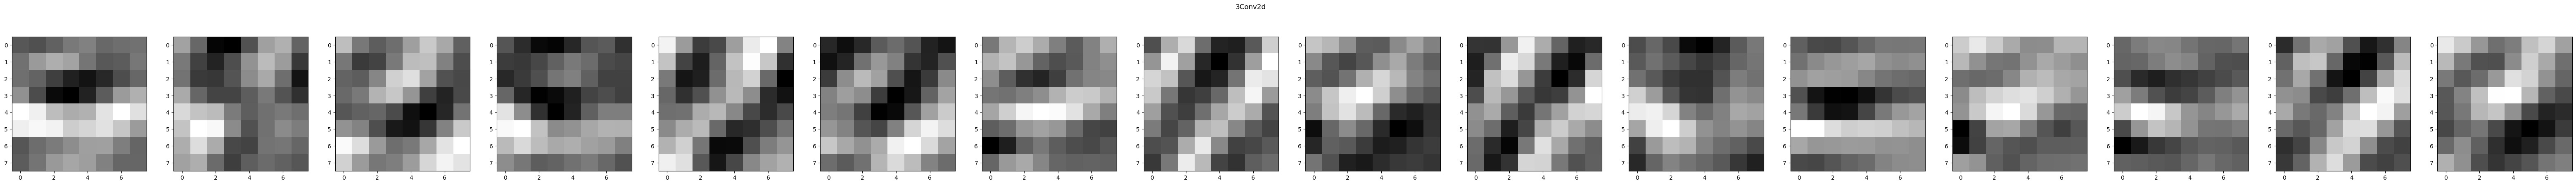

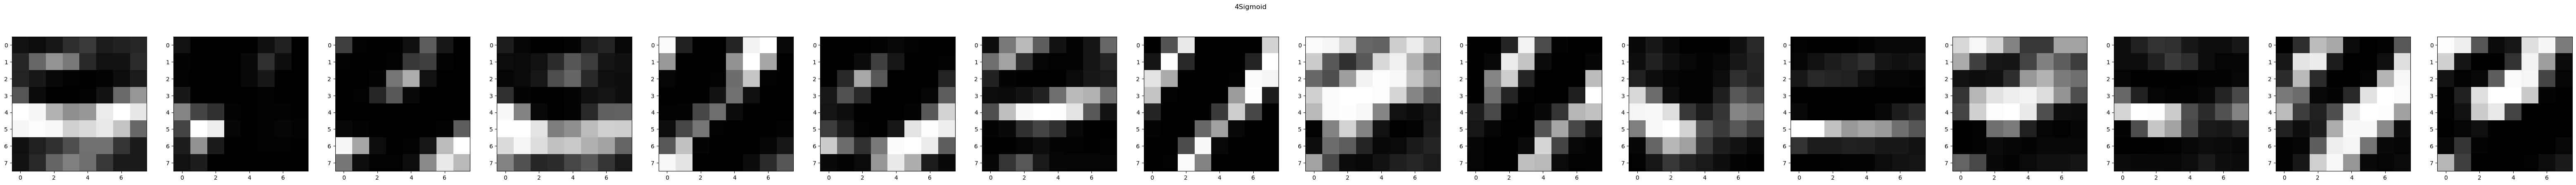

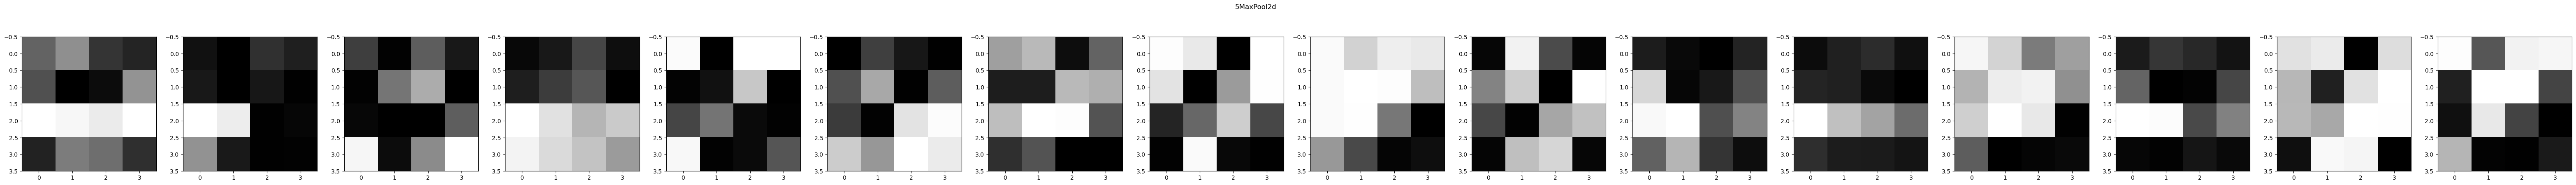

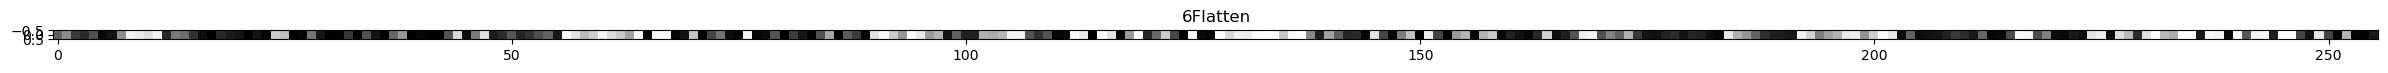

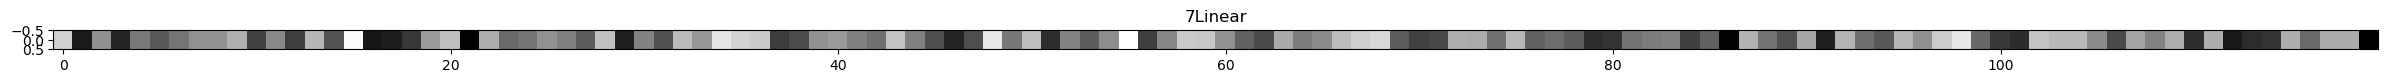

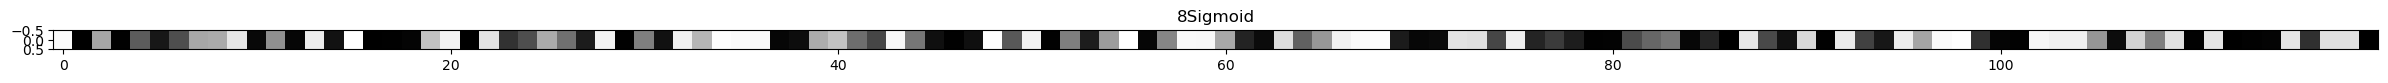

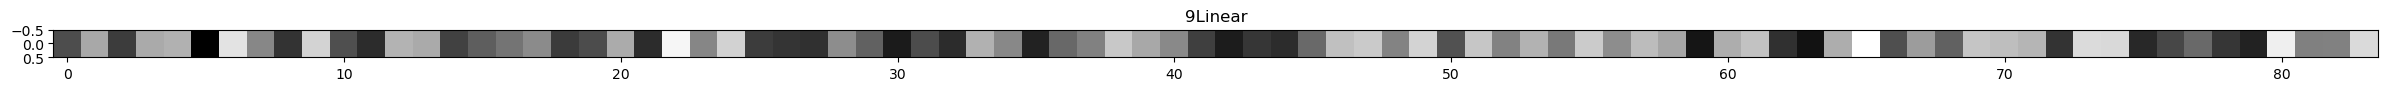

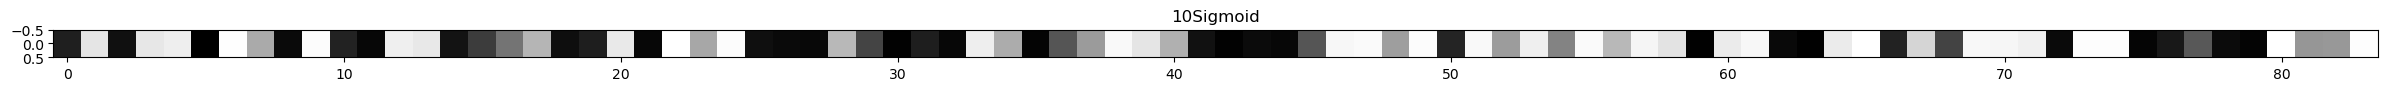

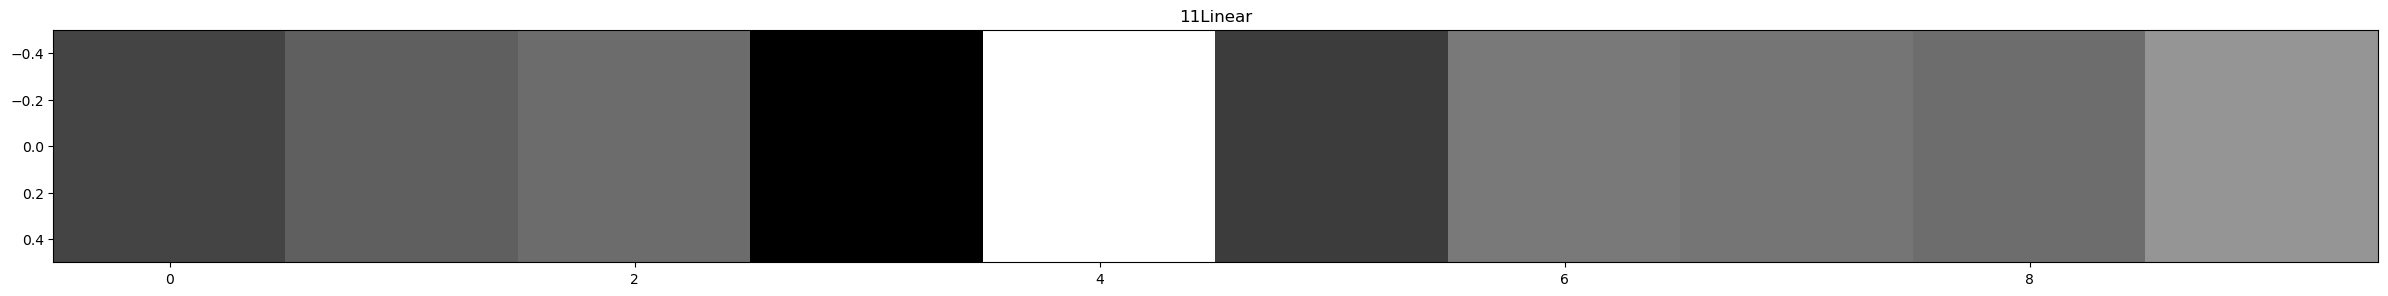

In [55]:
for name in features.keys():
    tensor = features[name].squeeze()
    if len(tensor.shape) > 1:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(tensor.shape[0]*5, 5))
        axes = axes.flatten()
        fig.suptitle(name)
        for ax, conv_val in zip(axes, tensor):
            ax.imshow(conv_val.cpu().detach(), cmap='gray')
    else:
        plt.figure(figsize=(30, 5))
        plt.title(name)
        plt.imshow(tensor[None, :].cpu().detach(), cmap='gray')

### PCA of last hidden layer

We have previously seen that for a particular classification problem, the last linear layer of the network learns partition the space into decision regions. We would expect the LeNet model to do the same for our 10 different digit classes. The problem is that it is hard to visualize the decision boundaries of these 10 classes, as the last linear layer has 84 dimensions. We preferably need 2 dimensions so that it can be illustrated on the $(x, y)$-plane. 

One possible solution to this problem is to use a dimensionality reduction technique. For example, **Principal Component Analysis** (PCA) tries to find $n$ new dimensions such that they retain as much variance of the original 84-dimensional data as possible. We will use this to project the test set onto 2 dimensions and visualize the 10 classes.  

In [57]:
h = lenet[10].register_forward_hook(get_features(f"last_layer"))
hook_handles.append(h)

In [80]:
X_test = test.dataset.data[test.indices].to(torch.float32)
y_test = test.dataset.targets[test.indices].to(torch.float32)

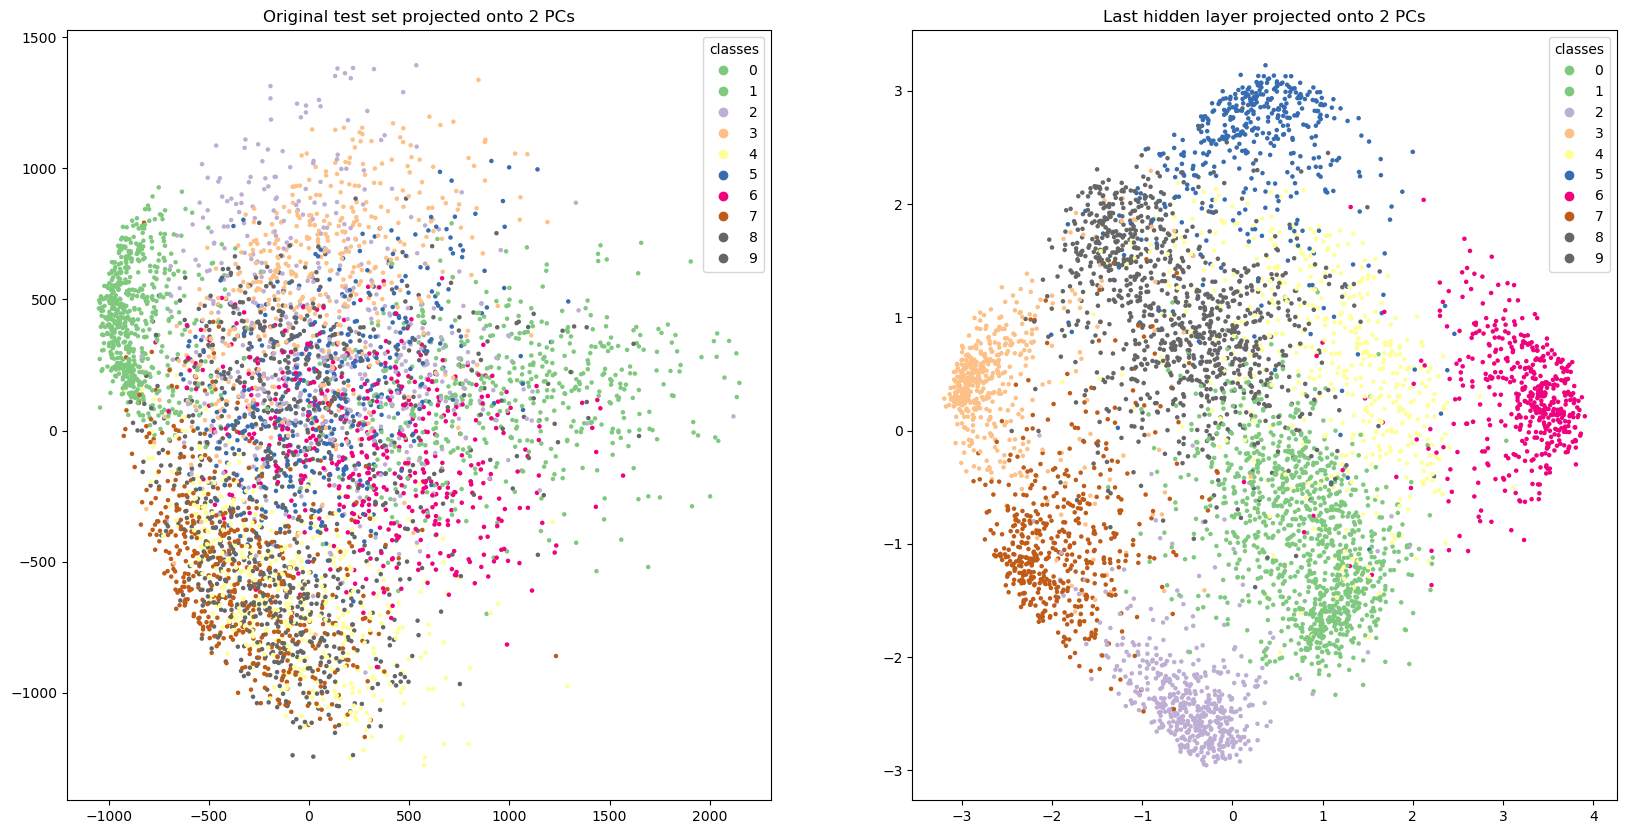

In [87]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X_test.reshape((5000, -1)))
lenet(X_test.unsqueeze(1).to(device))
hidden_X_pca = PCA(n_components=2).fit_transform(features['last_layer'].cpu().detach().numpy().reshape((5000, -1)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
sc1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test.numpy().tolist(), s=5, cmap='Accent')
ax1.legend(*sc1.legend_elements(), title='classes')
ax1.set_title('Original test set projected onto 2 PCs')

sc2 = ax2.scatter(hidden_X_pca[:, 0], hidden_X_pca[:, 1], c=y_test.numpy().tolist(), s=5, cmap='Accent')
ax2.legend(*sc2.legend_elements(), title='classes')
ax2.set_title('Last hidden layer projected onto 2 PCs')

plt.show()